# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


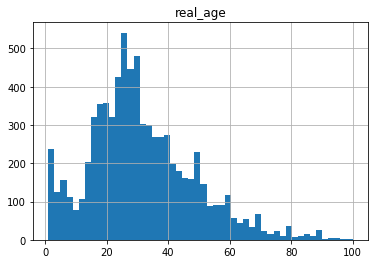

In [5]:
labels.hist(bins = 50);

Имеем условно бимодальное распределение с большим правым хвостом

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим структуру малых возрастов

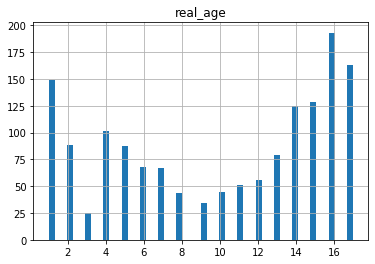

In [7]:
labels.query('real_age < 18').hist(bins = 50);

А теперь структуру возрастов после 60 

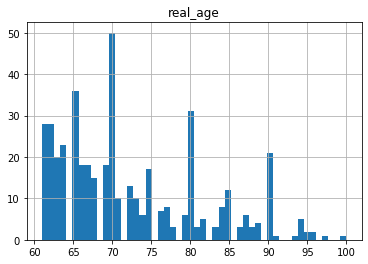

In [8]:
labels.query('real_age > 60').hist(bins = 50);

Очевидно что при таком распределении из - за количества изображений модель получит более 'разнообразный' опыт в диапазоне о 16 до 50 лет.  До этого диапазона и после него модель будет склонна к большим ошибкам.

In [9]:

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

    return train_datagen_flow

In [10]:
datagen_flow= load_train('/datasets/faces/final_files/')

Found 7591 validated image filenames.


In [12]:
features, target = next(datagen_flow)

Посмотрим изображения одного из батчей

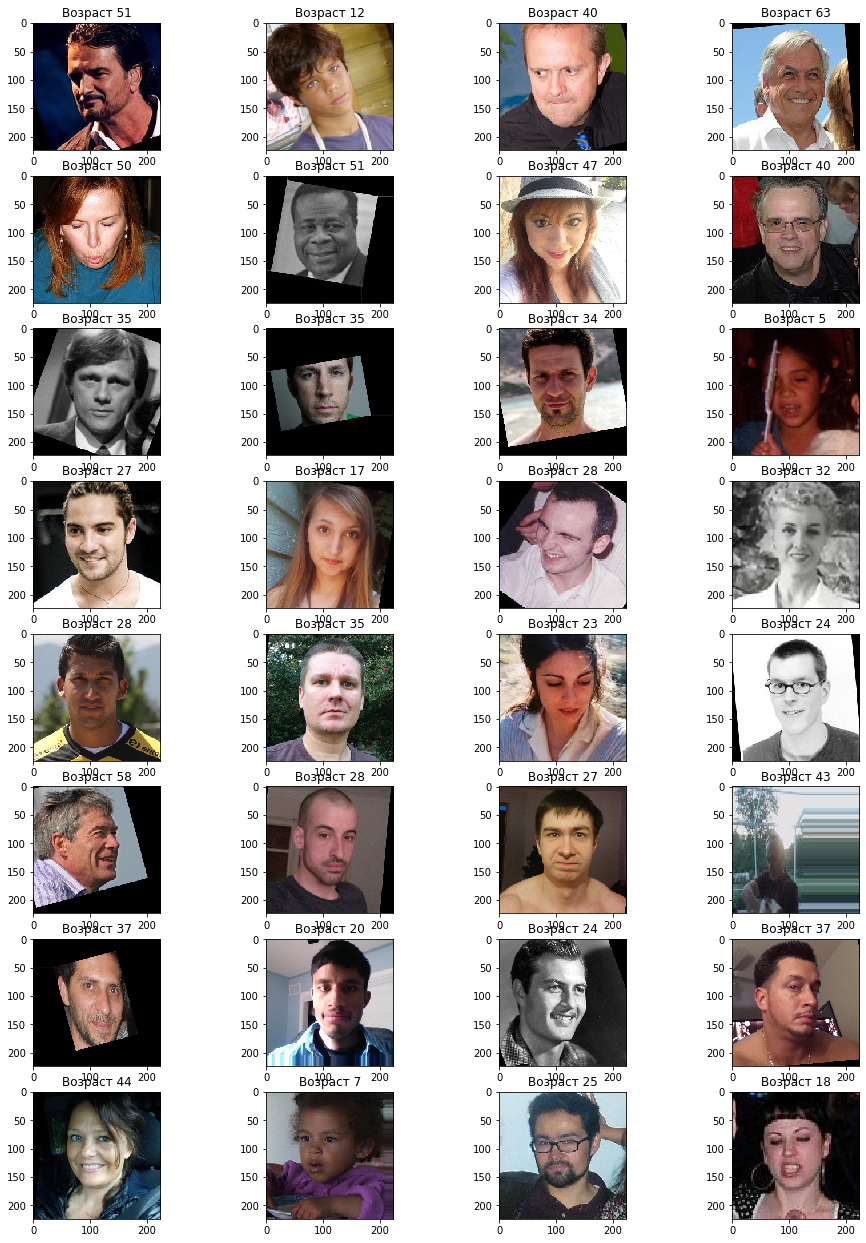

In [13]:
plt.figure(figsize = (16,22))
for i in range(1,33):
    ax = plt.subplot(8,4, i)
    ax.set_title('Возраст %d'%target[i-1])
    plt.imshow(features[i-1])


Вывод 1: более надежные прогнозы следует ожидать в диапазоне от 16-50 лет

Вывод 2: Исходя из визиального ощущения, положительно сыграет умеренная аугментация: вертикальный флип, небольшие углы поворота думаю градусов до 20-30, и небольшие вертикальные и горизонтальные смещения , думаю процентов 15% от размера изображения.

In [1]:
# < Перенесите сюда исследовательский анализ данных >

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.,
                                       horizontal_flip=True,        # Вертикальные отражения
                                       rotation_range=20,           # Повороты 20 градусов 
                                       width_shift_range=.1)        # Горизонтальные смещения картинки на 10% ширины 

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return train_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    # замораживаем ResNet50 без верхушки
    # backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=0.0003)
    model.compile(optimizer=optimizer_adam, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=9, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              epochs=epochs,
              validation_data=test_data,
              batch_size=batch_size,
              validation_steps=validation_steps,
              steps_per_epoch=steps_per_epoch,
              verbose=2)

    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/9
2021-06-16 10:05:22.657957: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-06-16 10:05:23.059229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 121s - loss: 207.5993 - mae: 10.7272 - val_loss: 395.6624 - val_mae: 14.9170
Epoch 2/9
178/178 - 113s - loss: 120.8666 - mae: 8.2670 - val_loss: 378.6449 - val_mae: 14.5303
Epoch 3/9
178/178 - 113s - loss: 103.1893 - mae: 7.7230 - val_loss: 285.4758 - val_mae: 12.7588
Epoch 4/9
178/178 - 113s - loss: 79.3069 - mae: 6.7680 - val_loss: 177.3748 - val_mae: 10.0576
Epoch 5/9
178/178 - 114s - loss: 70.8148 - mae: 6.4119 - val_loss: 151.5822 - val_mae: 9.6206
Epoch 6/9
178/178 - 113s - loss: 64.4141 - mae: 6.1158 - val_loss: 89.9591 - val_mae: 7.1025
Epoch 7/9
178/178 - 113s - loss: 56.6325 - mae: 5.7508 - val_loss: 95.8487 - val_mae: 7.3238
Epoch 8/9
178/178 - 113s - loss: 56.4397 - mae: 5.7352 - val_loss: 88.0327 - val_mae: 6.9063
Epoch 9/9
178/178 - 113s - loss: 50.4018 - mae: 5.4339 - val_loss: 100.4505 - val_mae: 7.5792

```

## Анализ обученной модели

### Этапы обучения


Основыне этапы в обучении. Изначально была взята за основу модель прошедщая заданный порог по ACC в задаче с фруктами, а именно:
1. ResNet50(weights='imagenet', include_top=False) - предобученая RESNET50 без последних слоев, без заморозки при обучении

2.  model.add(GlobalAveragePooling2D())

    model.add(Dense(1024, activation='relu'))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(24, activation='relu'))
    
    model.add(Dense(1, activation='relu')) шесть полносвязанных слоев с последним слоем с 1 нейроном.
    
3. optimizer_adam = Adam(lr=0.001) 

   model.compile(optimizer=optimizer_adam, loss='mean_squared_error', metrics=['mae']) Шаг обучения 0.001, функция ошибки MSE метрика MAE, 5 эпох

4. Аугментация горизонтальный флип, повороты 20 градусов, мещение по ширине 10%

1.На первом прогоне получился результат:

Epoch 1/5
178/178 - 200s - loss: 259.9697 - mae: 12.3541 - val_loss: 318.5972 - val_mae: 17.6900

Epoch 2/5
178/178 - 118s - loss: 195.4229 - mae: 10.8023 - val_loss: 455.9813 - val_mae: 16.2557

Epoch 3/5
178/178 - 118s - loss: 166.9540 - mae: 9.8516 - val_loss: 400.6767 - val_mae: 15.0587

Epoch 4/5
178/178 - 117s - loss: 148.0806 - mae: 9.2914 - val_loss: 264.9087 - val_mae: 12.3204

Epoch 5/5
178/178 - 118s - loss: 147.0409 - mae: 9.2403 - val_loss: 174.7175 - val_mae: 9.8340

Разумная ситуация с первого прогона, метрика снижается на трейне, снижается на тесте. По ощущениям не хватило пару тройку эпох

2. Ради спортивного интереса вторым прогоном решил проверить влияние аугментации, отключил


Epoch 1/5
178/178 - 111s - loss: 253.8265 - mae: 12.2061 - val_loss: 406.2632 - val_mae: 15.1605

Epoch 2/5
178/178 - 43s - loss: 171.5977 - mae: 10.0042 - val_loss: 303.3654 - val_mae: 12.9305

Epoch 3/5
178/178 - 43s - loss: 133.9771 - mae: 8.9019 - val_loss: 398.1767 - val_mae: 14.9770

Epoch 4/5
178/178 - 42s - loss: 104.9466 - mae: 7.8456 - val_loss: 281.0576 - val_mae: 12.5023

Epoch 5/5
178/178 - 42s - loss: 80.9405 - mae: 6.8926 - val_loss: 207.0412 - val_mae: 10.5530


Ситуация значимо изменилась, метрика на тесте запрыгала, что говорит о том что модель перезатачивается под конкретные трейновые картинки метрика сильно улучшилась, но на тестовых данных модель стала ошибаться сильнее

На дальнейших этапах аугментацию снова включил.

3. Далее несколько итераций по подгонке шага обучения, с 0.001 до 0.0003 - модель учится более плавно и меньше прыгает, что говорит о том что на большом шаге видимо модель проскакивает минимумы.

4. Далее несколько итераций со слоями - добавление начального слоя с 2048 нейронами - особой пользы не приносит, и второе это подбор предпоследнего слоя перд последним нейроном, увеличение нейронов в предпоследнем слое (с 24 до 128, 32)  ухудшало метрику и напротив снижение числа нейронов до 16 в совокупе с изложенными выше настроками позволило преодолеть заданный порог val_mae: 7.5792 

Train for 178 steps, validate for 60 steps
Epoch 1/9
178/178 - 121s - loss: 207.5993 - mae: 10.7272 - val_loss: 395.6624 - val_mae: 14.9170

Epoch 2/9
178/178 - 113s - loss: 120.8666 - mae: 8.2670 - val_loss: 378.6449 - val_mae: 14.5303

Epoch 3/9
178/178 - 113s - loss: 103.1893 - mae: 7.7230 - val_loss: 285.4758 - val_mae: 12.7588

Epoch 4/9
178/178 - 113s - loss: 79.3069 - mae: 6.7680 - val_loss: 177.3748 - val_mae: 10.0576

Epoch 5/9
178/178 - 114s - loss: 70.8148 - mae: 6.4119 - val_loss: 151.5822 - val_mae: 9.6206

Epoch 6/9
178/178 - 113s - loss: 64.4141 - mae: 6.1158 - val_loss: 89.9591 - val_mae: 7.1025

Epoch 7/9
178/178 - 113s - loss: 56.6325 - mae: 5.7508 - val_loss: 95.8487 - val_mae: 7.3238

Epoch 8/9
178/178 - 113s - loss: 56.4397 - mae: 5.7352 - val_loss: 88.0327 - val_mae: 6.9063

Epoch 9/9
178/178 - 113s - loss: 50.4018 - mae: 5.4339 - val_loss: 100.4505 - val_mae: 7.5792



После этого был еще эксперемент с уменьшение шага обучения до 0.0001 метрика еще улучшилась до val_mae: 6.22